In [1]:
import torch
import torch.nn
import torch.nn.functional as F

In [2]:
from model.encoder import Encoder
from model.decoder import Decoder

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [4]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
from matplotlib import cm
import numpy as np
from dataset import get_dataset, collate_fn, vocab_size, int2char, char2int, SOS_CHAR, EOS_CHAR
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import ScaleImageByHeight, PaddingWidth, AverageMeter, accuracy

In [5]:
config = {
    'batch_size': 32,
    'hidden_size': 256,
    'attn_size': 256,
    'max_length': 10,
    'n_epochs_decrease_lr': 15,
    'start_learning_rate': 1e-5,  # NOTE: paper start with 1e-8
    'end_learning_rate': 1e-11,
    'depth': 4,
    'n_blocks': 3,
    'growth_rate': 96,
}

In [6]:
MAX_LENGTH = config['max_length']
CKPT_DIR = './ckpt'

In [7]:
info = torch.load(os.path.join(CKPT_DIR, '02012020_223655/BEST_weights_56_0.9035624686402408.pt'), map_location='cpu')

In [8]:
image_transform = transforms.Compose([
    transforms.Grayscale(3),
    ScaleImageByHeight(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
test_data = get_dataset('test', image_transform)
test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn, num_workers=2)

In [10]:
encoder = Encoder(config['depth'], config['n_blocks'], config['growth_rate'])
if info['encoder_state'] is not None:
    encoder.load_state_dict(info['encoder_state'])

In [11]:
decoder = Decoder(encoder.n_features,
                  config['hidden_size'], vocab_size, config['attn_size'])
if info['decoder_state'] is not None:
    decoder.load_state_dict(info['decoder_state'])

In [12]:
encoder = encoder.to(device)
decoder = decoder.to(device)

In [13]:
encoder.eval()
decoder.eval();

In [14]:
test_iter = iter(test_loader)

In [15]:
imgs, targets, targets_onehot, lengths = next(test_iter)

In [16]:
imgs.size()

torch.Size([32, 3, 128, 396])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


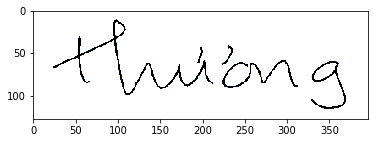

In [17]:
plt.imshow(imgs[0].squeeze().permute(1,2,0))

In [18]:
targets.size()

torch.Size([8, 32, 1])

In [19]:
''.join([int2char[x.item()] for x in targets[:,0].squeeze()])

'<start>thương<end>'

In [20]:
start_input = torch.zeros(1, config['batch_size'], vocab_size)
start_input[0,0, char2int[SOS_CHAR]] = 1
start_input = start_input.to(device)

In [21]:
with torch.no_grad():
#     for i, (imgs, targets, targets_onehot, lengths) in enumerate(val_loader):
    imgs = imgs.to(device)
    img_features = encoder(imgs)
    outputs, weights = decoder.greedy(img_features, start_input)

In [22]:
outputs.size()

torch.Size([10, 32, 150])

In [23]:
outputs

tensor([[[ 1.8638e+00, -5.9696e-01,  7.4219e-01,  ..., -1.7447e+00,
          -1.6931e+00, -1.2266e+00],
         [ 1.2485e+00, -6.5061e-01,  7.3133e-01,  ..., -2.0199e+00,
          -2.0367e+00, -1.5119e+00],
         [ 1.6489e+00, -4.5454e-01,  2.0363e-01,  ..., -1.7369e+00,
          -2.0501e+00, -1.5954e+00],
         ...,
         [ 1.1500e+00, -9.0042e-01,  1.6204e+00,  ..., -2.2862e+00,
          -2.4466e+00, -2.1726e+00],
         [ 8.5885e-01, -7.6511e-01,  1.6060e+00,  ..., -1.8442e+00,
          -2.1286e+00, -1.7298e+00],
         [ 1.4260e+00,  1.2648e+00,  1.0548e+00,  ..., -1.9019e+00,
          -1.7609e+00, -1.5714e+00]],

        [[-1.1032e+00,  7.8203e-01,  3.2326e-01,  ..., -2.3061e+00,
          -2.5279e+00, -2.2266e+00],
         [-5.8481e-01, -4.0003e-02, -1.0603e+00,  ..., -2.3778e+00,
          -2.6176e+00, -2.3515e+00],
         [ 4.4397e-01,  1.1664e+00,  6.4886e-01,  ..., -1.5407e+00,
          -2.7654e+00, -2.6218e+00],
         ...,
         [-1.6464e+00,  3

In [24]:
_, index = outputs.topk(1, -1)

In [25]:
index.size()

torch.Size([10, 32, 1])

In [26]:
predicts = index.squeeze().transpose(0, 1) # [B, T]
predicts_str = []
for predict in predicts:
    s = [int2char[x.item()] for x in predict]
    try:
        eos_index = s.index(EOS_CHAR) + 1
    except ValueError:
        eos_index = len(s)
    predicts_str.append(s[:eos_index])

predicts_str

[['<start>', 't', 'h', 'ư', 'a', 'n', 'g', '<end>'],
 ['<start>', 'h', 'u', 'y', 'ệ', 'n', '<end>'],
 ['<start>', 'T', 'h', 'à', 'n', 'h', '<end>'],
 ['<start>', 'n', 'g', 'ư', 'ờ', 'i', '<end>'],
 ['<start>', 't', 'ì', 'n', 'h', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'l', 'o', 'n', 'g', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'l', 'o', 'n', 'g', '<end>'],
 ['<start>', 'c', 'h', 'â', 'u', '<end>'],
 ['<start>', 'ô', 'n', 'g', '<end>'],
 ['<start>', 'g', 'i', 'à', '<end>'],
 ['<start>', 'n', 'ă', 'm', '<end>'],
 ['<start>', 'l', 'à', 'm', '<end>'],
 ['<start>', 'n', 'h', 'à', '<end>'],
 ['<start>', 'T', 'ô', 'i', '<end>'],
 ['<start>', 'g', 'ặ', 'p', '<end>'],
 ['<start>', 'ô', 'n', 'g', '<end>'],
 ['<start>', 'V', 'ă', 'n', '<end>'],
 ['<start>', 'T', 'á', 'm', '<end>'],
 ['<start>', 'n', 'g', 'ụ', '<end>'],
 ['<start>', 'B', 'ế', 'n', '<end>'],
 ['<start>', 'T', 'r', 'r', 'e', '<end>'],
 ['<start>', '3', '0', '<end>'],
 ['<start>', 

In [27]:
weights.size()

torch.Size([10, 32, 192])

In [28]:
img_rows, img_cols = imgs.size(2), imgs.size(3)
print(img_rows, img_cols)

128 396


In [29]:
length = len(predicts)
length

32

# Visualize a sample

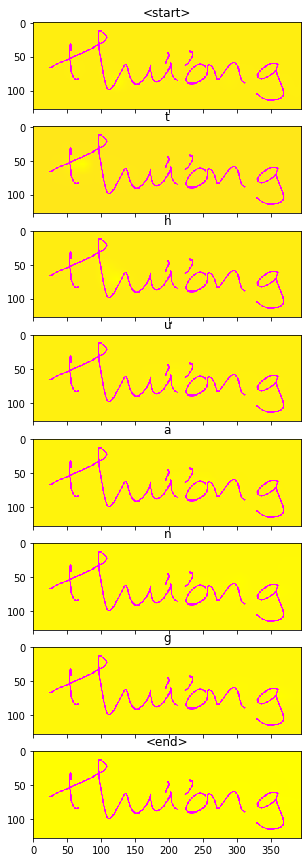

In [30]:
sample_index = 0
sample_image, sample_predict, sample_weigth = imgs[sample_index], predicts_str[sample_index], weights[:, [sample_index]]
fig, axeses = plt.subplots(len(sample_predict), figsize=(15,15), sharex=True, sharey=True)

for i, axes in enumerate(axeses.ravel()):
    weight = weights[i].reshape(-1, config['batch_size'], img_rows // 16, img_cols // 16) # 16 is factor that DenseNet reduce the original image size
    weight_numpy = weight.cpu().numpy()[:,sample_index,:].squeeze()
    weight_image = skimage.transform.resize(weight_numpy, (img_rows, img_cols))
    
    img = sample_image.squeeze().permute(1,2,0).cpu().numpy()[:,:,0]
    
    alpha = 0.5
    blend = img * alpha + weight_image * (1-alpha)
    
    axes.set_title(sample_predict[i])
    axes.imshow(blend, cmap='spring')
plt.plot();

# Calc CER, WER on the test set

## CER

In [31]:
import editdistance as ed

In [32]:
from tqdm.notebook import tqdm

In [34]:
total_characters = 0
total_words = 0
CE = 0
WE = 0
log_interval = 10

# t = tqdm(test_loader)
t = test_loader
with torch.no_grad():
    for i, (imgs, targets, targets_onehot, lengths) in enumerate(t):
        print(f'[{i}]/[{len(t)}]')
        batch_size = imgs.size(0)
        
        start_input = torch.zeros(1, batch_size, vocab_size)
        start_input[0,0, char2int[SOS_CHAR]] = 1
        start_input = start_input.to(device)
        imgs = imgs.to(device)
        
        img_features = encoder(imgs)
        outputs, weights = decoder.greedy(img_features, start_input)
        
        _, index = outputs.topk(1, -1)
        predicts = index.squeeze().transpose(0, 1) # [B, T]
        predicts_str = []
        for predict in predicts:
            s = [int2char[x.item()] for x in predict]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            predicts_str.append(s[:eos_index])

        targets_str = []
        for target in targets.transpose(0, 1).squeeze():
            s = [int2char[x.item()] for x in target]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            targets_str.append(s[:eos_index])
        
        assert len(predicts_str) == len(targets_str)
        for i in range(len(predicts_str)):
            CE += ed.distance(predicts_str[i], targets_str[i])
        total_characters += lengths.sum().item()
        
        for i in range(len(predicts_str)):
            WE += 1 if np.array_equal(np.array(predicts_str[i]), np.array(targets_str[i])) else 0
        total_words += len(predicts_str)
        
#         t.update()

[0]/[785]
[1]/[785]
[2]/[785]
[3]/[785]
[4]/[785]
[5]/[785]
[6]/[785]
[7]/[785]
[8]/[785]
[9]/[785]
[10]/[785]
[11]/[785]
[12]/[785]
[13]/[785]
[14]/[785]
[15]/[785]
[16]/[785]
[17]/[785]
[18]/[785]
[19]/[785]
[20]/[785]
[21]/[785]
[22]/[785]
[23]/[785]
[24]/[785]
[25]/[785]
[26]/[785]
[27]/[785]
[28]/[785]
[29]/[785]
[30]/[785]
[31]/[785]
[32]/[785]
[33]/[785]
[34]/[785]
[35]/[785]
[36]/[785]
[37]/[785]
[38]/[785]
[39]/[785]
[40]/[785]
[41]/[785]
[42]/[785]
[43]/[785]
[44]/[785]
[45]/[785]
[46]/[785]
[47]/[785]
[48]/[785]
[49]/[785]
[50]/[785]
[51]/[785]
[52]/[785]
[53]/[785]
[54]/[785]
[55]/[785]
[56]/[785]
[57]/[785]
[58]/[785]
[59]/[785]
[60]/[785]
[61]/[785]
[62]/[785]
[63]/[785]
[64]/[785]
[65]/[785]
[66]/[785]
[67]/[785]
[68]/[785]
[69]/[785]
[70]/[785]
[71]/[785]
[72]/[785]
[73]/[785]
[74]/[785]
[75]/[785]
[76]/[785]
[77]/[785]
[78]/[785]
[79]/[785]
[80]/[785]
[81]/[785]
[82]/[785]
[83]/[785]
[84]/[785]
[85]/[785]
[86]/[785]
[87]/[785]
[88]/[785]
[89]/[785]
[90]/[785]
[91]/[785

KeyboardInterrupt: 

In [ ]:
CER = CE / total_characters
WER = WE / total_words
print('CER', CER)
print('WER', WER)